In [6]:
'''Implementation of the ABC-SMC algorithm in https://www.pnas.org/doi/10.1073/pnas.0607208104'''

'Implementation of the ABC-SMC algorithm in https://www.pnas.org/doi/10.1073/pnas.0607208104'

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

In [8]:
'''Tau leaping model so we have some stochasticity. '''

days = 100
delta_t = 0.1 
rng = np.random.default_rng(0)

def model(theta,rng,*,days,delta_t,log = False): 
    beta,gamma = theta
    if log: 
        beta = np.exp(beta)
        gamma = np.exp(gamma)

    S = np.zeros(days * int(1/delta_t))
    I = np.zeros(days * int(1/delta_t))
    R = np.zeros(days * int(1/delta_t))

    #Initial condition
    S[0] = 500
    I[0] = 5
    R[0] = 0

    N = S[0] + I[0] + R[0]

    for t in range(1,int(1/delta_t) * days): 

        #Rate equations
        dN_SI = rng.poisson(max(beta * (S[t-1] * I[t-1]/N) * delta_t,0))
        dN_SI = min(dN_SI,S[t-1])

        dN_IR = rng.poisson(max(I[t-1] * gamma * delta_t,0))
        dN_IR = min(dN_IR,I[t-1])

        S[t] = S[t-1] - dN_SI
        I[t] = I[t-1] + dN_SI - dN_IR
        R[t] = R[t-1] + dN_IR

    return (S,I,R) 

theta = (0.3,0.1) #Real parameters
_,data_full,_ = model(theta,rng,days = days,delta_t = delta_t)


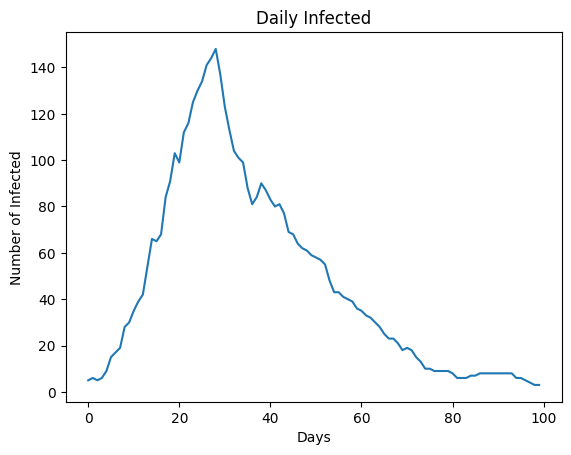

In [9]:
#Extract the data daily
data_real = data_full[::int(1/delta_t)]

plt.title('Daily Infected')
plt.xlabel('Days')
plt.ylabel('Number of Infected')
plt.plot(np.arange(0,days,1),data_real)

In [10]:
#Tempering parameters 
eps = np.flip(np.linspace(0,1000,20))

num_particles = 5_000

#Choosing the prior is quite important here
#We choose a normal distribution, remember we are in log-space
#normal(ln(1/2),ln(1/2),I))
prior = mvn(np.array([-np.log(2),-np.log(2)]),np.eye(2),seed = rng)

#Special case t = 0, draw the particles uniformly
particles = prior.rvs(size = (num_particles,))
weights = np.full((num_particles,),1/num_particles)

for iteration in range(1,len(eps)): 

    #Mutation/M-Kernel step

    particle_props = particles + 0.01 * rng.multivariate_normal(np.zeros(2),np.eye(2),size = (num_particles,))

    data_sets = np.zeros((num_particles,days))
    for index,p in enumerate(particles): 
        _,data_p,_ = model(p,rng,days = days,delta_t = delta_t,log = True)
        data_p = data_p[::int(1/delta_t)]

        distance = np.sqrt(np.sum((data_real - data_p)**2))

        #Weights
        if(distance < eps[iteration]): 
            weights[index] = prior.pdf(particles[index])/prior.pdf(particle_props[index])
            particles[index] = particle_props[index]

        #Store the data on last iteration, doing this after the perturbation is probably not correct
        if(iteration == (len(eps)-1)): 
            data_sets[index,:] = data_p

    #Normalize weights
    weights /= np.sum(weights)

    ESS = 1/np.sum(weights**2)
    print(f"ESS {ESS} on iteration {iteration}.")

    #Resampling
    indices = rng.choice(np.arange(num_particles),size = (num_particles,), replace = True, p = weights)
    particles = particles[indices,:]
    weights = np.full((num_particles,),1/num_particles)
    


ESS 4830.174057205326 on iteration 1.
ESS 4922.134974151914 on iteration 2.
ESS 4917.163907209167 on iteration 3.
ESS 4866.1772323917 on iteration 4.
ESS 4782.255477098507 on iteration 5.
ESS 4788.241425635752 on iteration 6.
ESS 4561.35270986344 on iteration 7.
ESS 799.5617521936383 on iteration 8.
ESS 2933.3143412297586 on iteration 9.
ESS 3438.9420108912254 on iteration 10.
ESS 3740.7535143799464 on iteration 11.
ESS 3516.907672688201 on iteration 12.
ESS 2974.19586188598 on iteration 13.
ESS 2387.503266600309 on iteration 14.
ESS 1758.8497182053638 on iteration 15.
ESS 1275.1462245337314 on iteration 16.
ESS 334.7945737996769 on iteration 17.
ESS 5000.000000000002 on iteration 18.
ESS 5000.000000000002 on iteration 19.


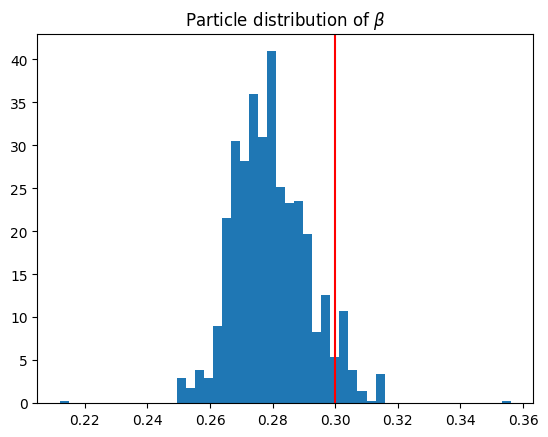

In [11]:
plt.title('Particle distribution of $\\beta$')
plt.hist(np.exp(particles[:,0]),bins = 50,density = True)
plt.axvline(theta[0],color = 'red')

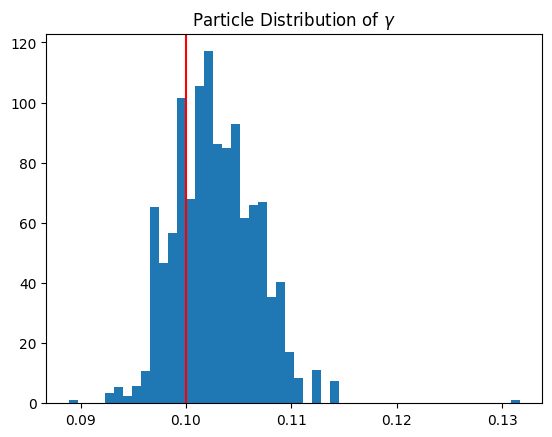

In [12]:
plt.title('Particle Distribution of $\\gamma$')
plt.hist(np.exp(particles[:,1]),bins = 50,density = True)
plt.axvline(theta[1],color = 'red')

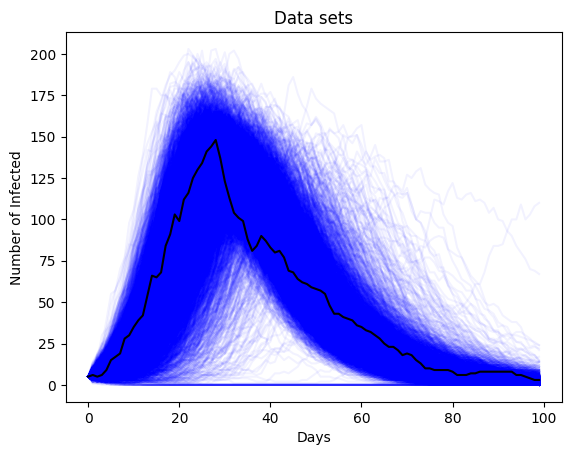

In [13]:
plt.title('Data sets')
plt.xlabel('Days')
plt.ylabel('Number of Infected')
plt.plot(np.arange(0,days,1),data_sets.T,color = 'blue',alpha = 0.05)
plt.plot(np.arange(0,days,1),data_real,color = 'black')
plt.show()